In [1]:
import torch
from scipy.special import comb
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
def generate_M(n, lambda_):
    """
    Generate the M matrix for a given n and lambda.

    Parameters:
        n (int): Number of variables (defines the size of the power set, 2^n).
        lambda_ (float): Smoothing parameter (0 <= lambda <= 1).

    Returns:
        torch.Tensor: The M matrix of size (2^n, 2^n).
    """
    # Generate all subsets of [n]
    subsets = list(itertools.chain.from_iterable(itertools.combinations(range(n), k) for k in range(n + 1)))
    num_subsets = len(subsets)

    # Initialize the M matrix
    M = torch.zeros((num_subsets, num_subsets), dtype=torch.float32)

    # Populate the M matrix
    for i, T in enumerate(subsets):
        for j, S in enumerate(subsets):
            if set(T).issubset(S):
                M[i, j] = (lambda_ ** len(T)) * ((1 - lambda_) ** (len(S) - len(T)))

    return M

In [3]:
def generate_P(n, lambda_):
    # Generate all subsets of [n]
    subsets = list(itertools.chain.from_iterable(itertools.combinations(range(n), k) for k in range(n + 1)))
    num_subsets = len(subsets)

    # Initialize the M matrix
    M = torch.zeros((num_subsets, num_subsets), dtype=torch.float32)

    # Populate the M matrix
    for i, T in enumerate(subsets):
        M[i,i] = lambda_ ** len(T)
    return M

In [4]:
def generate_averaging_matrix(n):    
    # Initialize the matrix A with zeros
    A = torch.zeros((n + 1, 2**n), dtype=torch.float32)
    
    # Start index for each block
    start_index = 0
    
    for k in range(n + 1):
        # Calculate the size of the current block
        block_size = comb(n, k, exact=True)
        
        # Assign equal weights to the corresponding contiguous block
        A[k, start_index : start_index + block_size] = 1.0 / block_size
        
        # Update the start index for the next block
        start_index += block_size
    
    return A

In [5]:
# Make some M_lambda
n = 10
A = generate_averaging_matrix(n)
start_time = time.time()
M_7 = generate_M(n, 0.7)
print(f"Elapsed: {time.time() - start_time:.3f}"); start_time = time.time()
M_8 = generate_M(n, 0.8)
print(f"Elapsed: {time.time() - start_time:.3f}"); start_time = time.time()
M_9 = generate_M(n, 0.9)
print(f"Elapsed: {time.time() - start_time:.3f}")

P_7 = generate_P(n, 0.7)
P_8 = generate_P(n, 0.8)
P_9 = generate_P(n, 0.9)

Elapsed: 0.830
Elapsed: 0.676
Elapsed: 0.858


In [39]:
torch.random.manual_seed(10)
x = torch.randn(2 ** n)
Ax = (A @ x.view(-1, 1).abs()).view(-1)
AMx_7 = (A @ (M_7 @ x.view(-1,1)).abs()).view(-1)
AMx_8 = (A @ (M_8 @ x.view(-1,1)).abs()).view(-1)
AMx_9 = (A @ (M_9 @ x.view(-1,1)).abs()).view(-1)

y = x.abs()
Ay = (A @ y.view(-1, 1).abs()).view(-1)
AMy_7 = (A @ (M_7 @ y.view(-1,1)).abs()).view(-1)
AMy_8 = (A @ (M_8 @ y.view(-1,1)).abs()).view(-1)
AMy_9 = (A @ (M_9 @ y.view(-1,1)).abs()).view(-1)

# P
Ax = (A @ x.view(-1, 1).abs()).view(-1)
APx_7 = (A @ (P_7 @ x.view(-1,1)).abs()).view(-1)
APx_8 = (A @ (P_8 @ x.view(-1,1)).abs()).view(-1)
APx_9 = (A @ (P_9 @ x.view(-1,1)).abs()).view(-1)

y = x.abs()
Ay = (A @ y.view(-1, 1).abs()).view(-1)
APy_7 = (A @ (P_7 @ y.view(-1,1)).abs()).view(-1)
APy_8 = (A @ (P_8 @ y.view(-1,1)).abs()).view(-1)
APy_9 = (A @ (P_9 @ y.view(-1,1)).abs()).view(-1)

<Figure size 640x480 with 0 Axes>

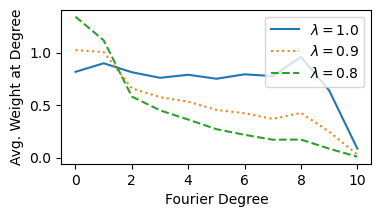

In [40]:
fs = 14
plt.clf()
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(Ax.numpy(), label="$\lambda = 1.0$", linestyle="solid")
ax.plot(AMx_9.numpy(), label="$\lambda = 0.9$", linestyle="dotted")
ax.plot(AMx_8.numpy(), label="$\lambda = 0.8$", linestyle="dashed")
ax.set_xlabel("Fourier Degree")
ax.set_ylabel("Avg. Weight at Degree")
ax.legend(loc="upper right")
plt.savefig("../figures/example_spectrum_mask.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

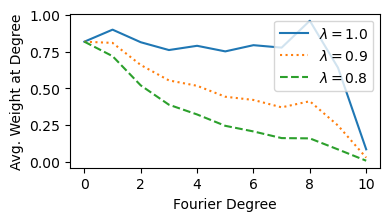

In [41]:
fs = 14
plt.clf()
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(Ax.numpy(), label="$\lambda = 1.0$", linestyle="solid")
ax.plot(APx_9.numpy(), label="$\lambda = 0.9$", linestyle="dotted")
ax.plot(APx_8.numpy(), label="$\lambda = 0.8$", linestyle="dashed")
ax.set_xlabel("Fourier Degree")
ax.set_ylabel("Avg. Weight at Degree")
ax.legend(loc="upper right")
plt.savefig("../figures/example_spectrum_flip.pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

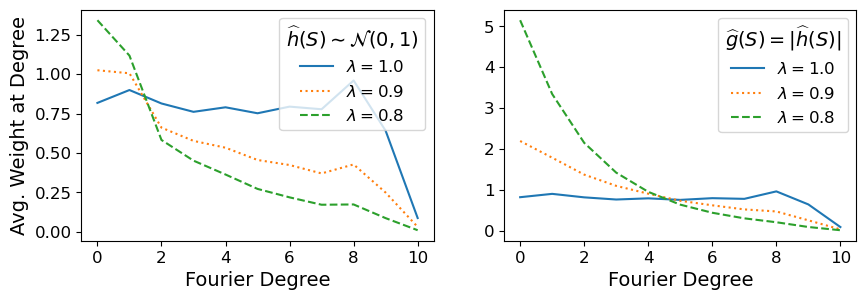

In [9]:
fs = 14

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(Ax.numpy(), label="$\lambda = 1.0$", linestyle="solid")
ax[0].plot(AMx_9.numpy(), label="$\lambda = 0.9$", linestyle="dotted")
ax[0].plot(AMx_8.numpy(), label="$\lambda = 0.8$", linestyle="dashed")
# ax[0].plot(AMx_7.numpy(), label="$\lambda = 0.7$", linestyle="dashdot")

ax[1].plot(Ay.numpy(), label="$\lambda = 1.0$", linestyle="solid")
ax[1].plot(AMy_9.numpy(), label="$\lambda = 0.9$", linestyle="dotted")
ax[1].plot(AMy_8.numpy(), label="$\lambda = 0.8$", linestyle="dashed")
# ax[1].plot(AMy_7.numpy(), label="$\lambda = 0.7$", linestyle="dashdot")

ax[0].legend(title="$\widehat{h}(S) \sim \mathcal{N}(0,1)$", loc="upper right", fontsize=fs-2, title_fontsize=fs)
ax[1].legend(title="$\widehat{g}(S) = |\widehat{h}(S)|$", loc="upper right", fontsize=fs-2, title_fontsize=fs)
ax[0].set_ylabel("Avg. Weight at Degree", fontsize=fs)

for i in [0, 1]:
    ax[i].set_xlabel("Fourier Degree", fontsize=fs)
    # ax[i].legend(loc="upper right")

    ax[i].tick_params(axis='x', labelsize=fs-2)  # Set x-axis tick font size
    ax[i].tick_params(axis='y', labelsize=fs-2)  # Set y-axis tick font size
plt.savefig("../figures/example_spectrum.pdf", bbox_inches="tight")